# Midterm Project

## 20223888 이선우

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score

from warnings import filterwarnings

filterwarnings('ignore')

## 1) Data Preprocessing

In [2]:
data = pd.read_csv('./Data/RAWDATA.csv', index_col=0)

'''Index 맞춰준거'''

X_train = pd.concat([data[data.columns[:-1]][0:1700], data[data.columns[:-1]][2000:3000]])
y_train = pd.concat([data['Yc'][0:1700], data['Yc'][2000:3000]])
X_test = pd.concat([data[data.columns[:-1]][1700:2000], data[data.columns[:-1]][3000:]])
y_test = pd.concat([data['Yc'][1700:2000], data['Yc'][3000:]])

'''Don't Touch!!!'''

"Don't Touch!!!"

In [146]:
y_train.value_counts(), y_test.value_counts()

(1.0    1418
 0.0    1282
 Name: Yc, dtype: int64,
 1.0    346
 0.0    298
 Name: Yc, dtype: int64)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.fit_transform(X_test)

X_train_sc.shape, X_test_sc.shape

((2700, 22), (644, 22))

## 2) Classifying Data

### 2-1) Logistic Regression

In [4]:
def eval_list(y_test, y_pred):
    '''accuracy, precision, recall, F1'''

    cm = confusion_matrix(y_test, y_pred)
    Accuracy = (cm[0, 0] + cm[1, 1]) / sum(cm.reshape(-1, ))
    Precision = cm[1, 1] /sum(cm[:, 1])
    Recall = cm[1, 1] / sum(cm[1])
    F1 = 2 * Recall * Precision / (Recall + Precision)

    return ([Accuracy, Precision, Recall, F1])

In [167]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression()

lgr.fit(X_train_sc, y_train)
coef = pd.Series( data = np.round(lgr.coef_[0], 4), index = X_train.columns).sort_values(ascending=False)
coef.head()

SslowD       0.2939
ema20        0.2836
SMIsignal    0.2472
sma20        0.2270
BBmavg       0.2270
dtype: float64

<AxesSubplot:>

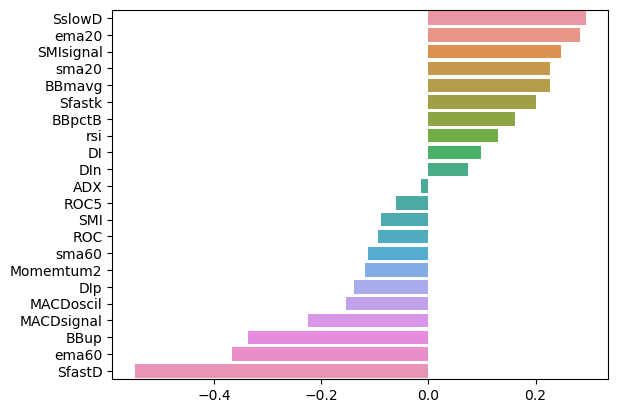

In [169]:
sns.barplot(coef, coef.index)

In [150]:
accuracy_score(y_test, lgr.predict(X_test_sc)), f1_score(y_test, lgr.predict(X_test_sc))

(0.5295031055900621, 0.6059817945383615)

## 2-2) DecisionTree

Fitting 5 folds for each of 16245 candidates, totalling 81225 fits
{'max_depth': 2, 'max_leaf_nodes': 3, 'min_samples_leaf': 50, 'min_samples_split': 2} 0.9441696113074205 

Accuracy : 0.53727 [0.5372670807453416, 0.5372670807453416, 1.0, 0.698989898989899] 



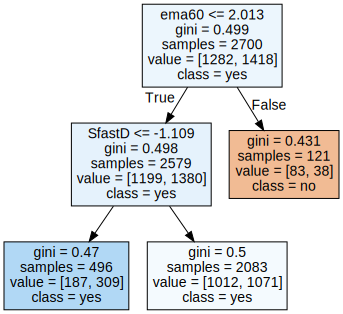

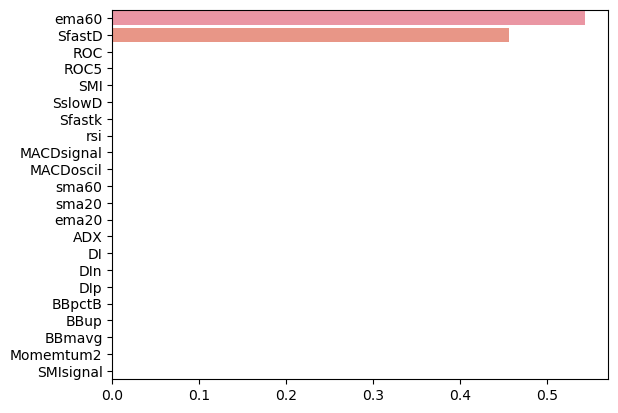

In [154]:
import graphviz
import seaborn as sns

from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

'''parameter tuning'''

params = {
    'max_depth' : list(np.arange(1, 6 ,1)),
    'min_samples_split' : list(np.arange(1, 10 ,1)),
    'min_samples_leaf' : list(np.arange(50, 1000 ,50)),
    'max_leaf_nodes' : list(np.arange(1, 20 ,1))
}

tr = DecisionTreeClassifier(random_state=1)

grid_tr = GridSearchCV(tr, param_grid=params, cv=5, scoring='recall', refit=True, verbose=1, n_jobs=-1)
grid_tr.fit(X_train_sc, y_train)
tr_score_df = pd.DataFrame(grid_tr.cv_results_)

print(grid_tr.best_params_, grid_tr.best_score_, '\n')

'''tuning result applying'''

tr_tuned = grid_tr.best_estimator_
y_pred_tr = tr_tuned.predict(X_test_sc)

print('Accuracy :', np.round(accuracy_score(y_test, y_pred_tr),5), eval_list(y_test, y_pred_tr), '\n', sep=' ')

'''feature importances'''

feature_imp = pd.Series(tr_tuned.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)

'''graphviz expression'''

export_graphviz(
    tr_tuned,
    out_file = 'decision_tree.dot',
    class_names = ['no','yes'],
    feature_names = X_train.columns,
    impurity=True, filled=True
)

treedot = graphviz.Source(open('decision_tree.dot').read())
treedot

In [155]:
print('Accuracy :', np.round(accuracy_score(y_test, y_pred_tr),5), eval_list(y_test, y_pred_tr), '\n', sep=' ')

Accuracy : 0.53727 [0.5372670807453416, 0.5372670807453416, 1.0, 0.698989898989899] 



In [156]:
import graphviz

treedot = graphviz.Source(open('decision_tree.dot').read())
treedot.format = 'pdf'
treedot.render('tree')

'tree.pdf'

In [157]:
grid_tr.best_params_

{'max_depth': 2,
 'max_leaf_nodes': 3,
 'min_samples_leaf': 50,
 'min_samples_split': 2}

## 앙상블 > 배깅

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:747: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py:753: RuntimeWarning: invalid value encountered in true_divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.new

{'base_estimator__max_depth': 1, 'base_estimator__max_leaf_nodes': 2, 'base_estimator__min_samples_leaf': 50, 'base_estimator__min_samples_split': 2, 'max_samples': 0.6000000000000001, 'n_estimators': 23}
0.5403726708074534 [0.5403726708074534, 0.5428082191780822, 0.9161849710982659, 0.6817204301075269]


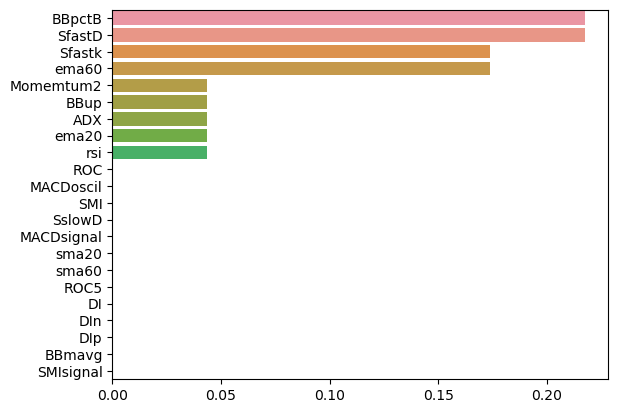

In [158]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


bag = BaggingClassifier(DecisionTreeClassifier(random_state=1), bootstrap=True, oob_score=True, random_state=3)
#bag.fit(X_train_sc, y_train)
#bag.oob_score_
#accuracy_score(y_test, bag.predict(X_test_sc))

params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_split' : [1, 2],
    'base_estimator__min_samples_leaf' : [10, 30, 50],
    'base_estimator__max_leaf_nodes' : [1, 2],

    'n_estimators' : list(np.arange(10, 30 ,1)),
    'max_samples' : list(np.arange(0.2, 0.8, 0.2)),
}

grid_bag = GridSearchCV(bag, param_grid=params, cv=5, scoring='recall', refit=True, verbose=1, n_jobs=-1)
grid_bag.fit(X_train_sc, y_train)

bag_score_df = pd.DataFrame(grid_bag.cv_results_)

print(grid_bag.best_params_)

bag_tuned = grid_bag.best_estimator_

print(accuracy_score(y_test, bag_tuned.predict(X_test_sc)), eval_list(y_test, bag_tuned.predict(X_test_sc)))

feature_imp_bag = np.mean([tree.feature_importances_ for tree in bag_tuned.estimators_],axis=0)
feature_imp_bag = pd.Series(feature_imp_bag, index=X_train.columns).sort_values(ascending=False)

sns.barplot(feature_imp_bag, feature_imp_bag.index)
plt.show()


In [159]:
grid_bag.best_params_

{'base_estimator__max_depth': 1,
 'base_estimator__max_leaf_nodes': 2,
 'base_estimator__min_samples_leaf': 50,
 'base_estimator__min_samples_split': 2,
 'max_samples': 0.6000000000000001,
 'n_estimators': 23}

In [160]:
bag_tuned = grid_bag.best_estimator_
print('Accuracy :', accuracy_score(y_test, bag_tuned.predict(X_test_sc)), eval_list(y_test, bag_tuned.predict(X_test_sc)), '\n', sep=' ')

Accuracy : 0.5403726708074534 [0.5403726708074534, 0.5428082191780822, 0.9161849710982659, 0.6817204301075269] 



<AxesSubplot:>

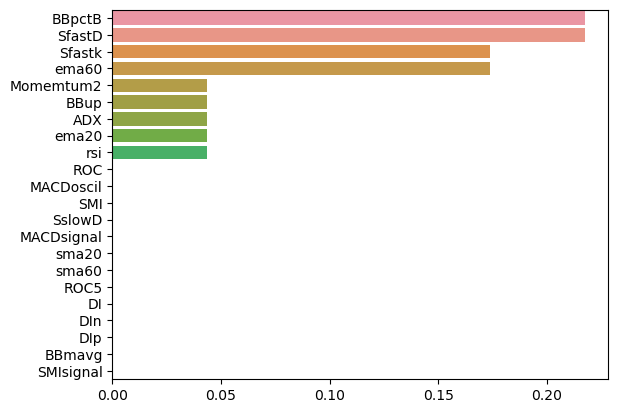

In [161]:
feature_imp_bag = np.mean([tree.feature_importances_ for tree in bag_tuned.estimators_],axis=0)

feature_imp_bag = pd.Series(feature_imp_bag, index=X_train.columns).sort_values(ascending=False)
sns.barplot(feature_imp_bag, feature_imp_bag.index)

## 앙상블 > RandomForest

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
{'max_depth': 1, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.6803165281441298
Accuracy : 0.53261 [0.532608695652174, 0.5356576862123613, 0.976878612716763, 0.6919140225179119] 



<AxesSubplot:>

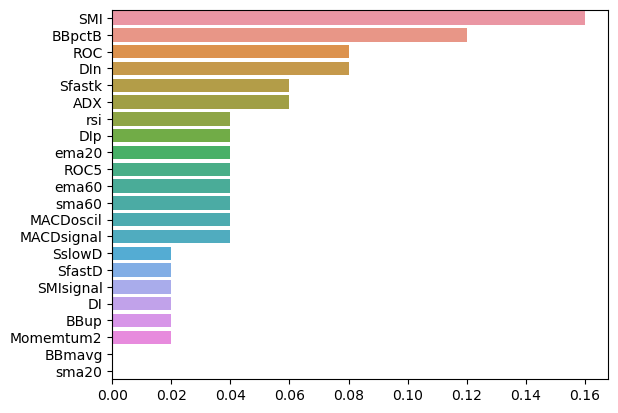

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0, oob_score=True)

params = {
    'n_estimators': list(np.arange(50, 150 ,50)),
    'max_features': list(np.arange(1, 5, 1)),
    'max_depth': list(np.arange(1, 5 ,1)),
    'min_samples_split': list(np.arange(1, 5 ,1)),
    'min_samples_leaf': list(np.arange(1, 5 ,1)),
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=5, scoring='recall', refit=True, verbose=1, n_jobs=-1)

grid_rf.fit(X_train_sc, y_train)
rf_score_df = pd.DataFrame(grid_rf.cv_results_)

print(grid_rf.best_params_, grid_rf.best_score_, sep='\n')

rf_tuned = grid_rf.best_estimator_
y_pred_rf = rf_tuned.predict(X_test_sc)

print('Accuracy :', np.round(accuracy_score(y_test, y_pred_rf),5), eval_list(y_test, y_pred_rf), '\n', sep=' ')

'''feature importances'''

feature_imp = pd.Series(rf_tuned.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)


In [231]:
print(grid_rf.best_params_, grid_rf.best_score_, sep='\n')

{'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
0.6584482157965461


In [230]:
print('Accuracy :', np.round(accuracy_score(y_test, y_pred_rf),5), eval_list(y_test, y_pred_rf), '\n', sep=' ')

Accuracy : 0.52795 [0.5279503105590062, 0.5330188679245284, 0.9797687861271677, 0.6904276985743381] 



# 앙상블 > Adaboost

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
{'base_estimator__max_depth': 1, 'base_estimator__max_leaf_nodes': 2, 'base_estimator__min_samples_leaf': 50, 'base_estimator__min_samples_split': 2, 'n_estimators': 12}
0.574421440302593
Accuracy : 0.47671 [0.4767080745341615, 0.5096359743040685, 0.6878612716763006, 0.5854858548585485] 



<AxesSubplot:>

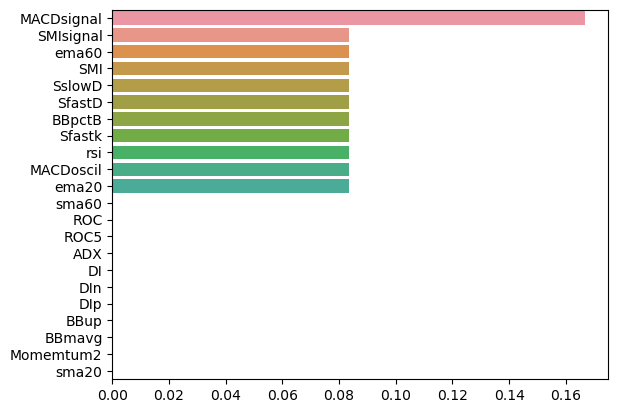

In [193]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ad = AdaBoostClassifier(DecisionTreeClassifier(random_state=1), random_state=1, algorithm='SAMME.R')

params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_split' : [1, 2],
    'base_estimator__min_samples_leaf' : [10, 30, 50],
    'base_estimator__max_leaf_nodes' : [1, 2],
    
    'n_estimators': list(np.arange(10, 50, 1)),
}

grid_ad = GridSearchCV(ad, param_grid=params, cv=5, scoring='recall', refit=True, verbose=1, n_jobs=-1)

grid_ad.fit(X_train_sc, y_train)
ad_score_df = pd.DataFrame(grid_ad.cv_results_)

print(grid_ad.best_params_, grid_ad.best_score_, sep='\n')

ad_tuned = grid_ad.best_estimator_
y_pred_ad = ad_tuned.predict(X_test_sc)

print('Accuracy :', np.round(accuracy_score(y_test, y_pred_ad),5), eval_list(y_test, y_pred_ad), '\n', sep=' ')

'''feature importances'''

feature_imp = pd.Series(ad_tuned.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)


In [194]:
grid_ad.best_params_, grid_ad.best_score_

({'base_estimator__max_depth': 1,
  'base_estimator__max_leaf_nodes': 2,
  'base_estimator__min_samples_leaf': 50,
  'base_estimator__min_samples_split': 2,
  'n_estimators': 12},
 0.574421440302593)

In [195]:
print('Accuracy :', np.round(accuracy_score(y_test, y_pred_ad),5), eval_list(y_test, y_pred_ad), '\n', sep=' ')

Accuracy : 0.47671 [0.4767080745341615, 0.5096359743040685, 0.6878612716763006, 0.5854858548585485] 



In [215]:
ad_check = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2, min_samples_leaf=50, min_samples_split=2, random_state=1), random_state=1, n_estimators=12, algorithm='SAMME.R')
ad_check.fit(X_train_sc, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         max_leaf_nodes=2,
                                                         min_samples_leaf=50,
                                                         random_state=1),
                   n_estimators=12, random_state=1)

In [216]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val= train_test_split( X_train_sc, y_train,
                                           test_size=0.4, random_state=123)

errors = [ accuracy_score(y_val, y_valpred) for y_valpred in ad_check.staged_predict(X_val)]
bst_n_estimators = np.argmin( errors )
bst_n_estimators

0

Text(0, 0.5, 'accuracy')

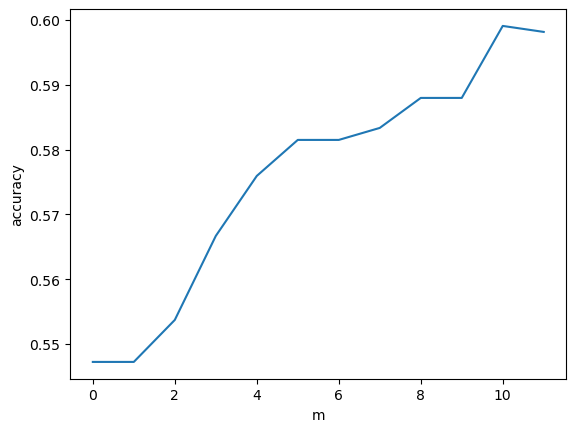

In [217]:
plt.plot(errors)
plt.xlabel('m')
plt.ylabel('accuracy')

## Ensemble Voting

In [37]:
grid_tr.best_params_, grid_bag.best_params_, grid_rf.best_params_, grid_ad.best_params_

({'max_depth': 2,
  'max_leaf_nodes': 3,
  'min_samples_leaf': 50,
  'min_samples_split': 2},
 {'base_estimator__max_depth': 1,
  'base_estimator__max_leaf_nodes': 2,
  'base_estimator__min_samples_leaf': 50,
  'base_estimator__min_samples_split': 2,
  'max_samples': 0.6000000000000001,
  'n_estimators': 23},
 {'max_depth': 1,
  'max_features': 1,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 50},
 {'base_estimator__max_depth': 1,
  'base_estimator__max_leaf_nodes': 2,
  'base_estimator__min_samples_leaf': 50,
  'base_estimator__min_samples_split': 2,
  'n_estimators': 2})

In [132]:
from sklearn.ensemble import VotingClassifier
from itertools import combinations as cm

vc_results_soft = {}
vc_results_hard = {}

models = [
    ('lgr', LogisticRegression()),
    ('dt', DecisionTreeClassifier(max_depth= 2,\
                                  max_leaf_nodes= 3,\
                                  min_samples_leaf= 50,\
                                  min_samples_split= 2, random_state=1)),
    ('bag', BaggingClassifier(DecisionTreeClassifier(max_depth=1,\
                                                     max_leaf_nodes=2,\
                                                     min_samples_leaf=50,\
                                                     min_samples_split=2,\
                                                     random_state=1),\
                              max_samples=0.6, n_estimators=23, bootstrap=True, oob_score=True, random_state=3)),
    ('rf', RandomForestClassifier(max_depth=1,\
                                  max_features=1,\
                                  min_samples_leaf=1,\
                                  min_samples_split=2,\
                                  n_estimators=50,random_state=0, oob_score=True)),
    ('ad', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,\
                                                     max_leaf_nodes=2,\
                                                     min_samples_leaf=50,\
                                                     min_samples_split=2,\
                                                     random_state=1), random_state=1, algorithm='SAMME.R'))
]

for iters in range(2,6):
    for comb in list(cm(tmp,iters)):
        model_fit = []
        
        for idx in comb:    
            model_fit.append(models[idx])
        
        vc = VotingClassifier(model_fit, voting='soft', n_jobs=-1)
        vc.fit(X_train_sc, y_train)
        vc_results_soft[comb] = eval_list(y_test, vc.predict(X_test_sc))[0]

        vc = VotingClassifier(model_fit, voting='hard', n_jobs=-1)
        vc.fit(X_train_sc, y_train)
        vc_results_hard[comb] = eval_list(y_test, vc.predict(X_test_sc))[0]


if max(vc_results_hard.values()) >= max(vc_results_soft.values()):
    checker = vc_results_hard
    method = 'hard'
else:
    checker = vc_results_soft
    method = 'soft'

best_vs, acc = max(checker, key=checker.get), max(checker.values())

print(f'best combination : {[ models[x][0] for x in best_vs]} with "{method}" voting & Accuracy is {np.round(acc, 5)}')

/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

best combination : ['lgr', 'bag'] with "hard" voting & Accuracy is 0.54348


In [137]:
models = [
    ('lgr', LogisticRegression()),

    ('bag', BaggingClassifier(DecisionTreeClassifier(max_depth=1,\
                                                     max_leaf_nodes=2,\
                                                     min_samples_leaf=50,\
                                                     min_samples_split=2,\
                                                     random_state=1),\
                              max_samples=0.6, n_estimators=23, bootstrap=True, oob_score=True, random_state=3)),]

vc = VotingClassifier(models, voting='hard', n_jobs=-1)
vc.fit(X_train_sc, y_train)
print(eval_list(y_test, vc.predict(X_test_sc)))


[0.5434782608695652, 0.565, 0.653179190751445, 0.6058981233243967]


/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Appendix.
## Voting 튜닝 시도 > But Failed (Time Constraints)

In [254]:
'''튜닝 불가!'''

from sklearn.ensemble import VotingClassifier

models = [
    ('lgr', LogisticRegression()),
    ('dt', DecisionTreeClassifier(random_state=1)),
    ('rf', RandomForestClassifier(random_state=1, oob_score=True)),
    ('ad', AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=1, algorithm='SAMME.R')),
    ('bg', BaggingClassifier(DecisionTreeClassifier(max_depth=1), bootstrap=True, oob_score=True, random_state=3))
]

vc = VotingClassifier(models, voting='soft', n_jobs=-1)

params = {
    'dt__max_depth': [1, 2, 3],
    'dt__min_samples_split' : [1, 2, 3, 4, 5],
    'dt__min_samples_leaf' : [50, 100, 150, 200],
    'dt__max_leaf_nodes' : [2, 4, 6, 8, 10],

    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': [3, 4, 5, 6],
    'rf__max_depth': [1, 2, 3],
    'rf__min_samples_split': [1, 2, 3],
    'rf__min_samples_leaf': [1, 2, 3],

    'ad__n_estimators': [50, 100, 150],

    'bg__n_estimators': [5, 10, 15, 20, 25, 30],
    'bg__max_samples': [0.2, 0.4, 0.6, 0.8],
}

grid_vc = GridSearchCV(estimator=vc, param_grid=params, cv=3, scoring='recall', refit=True, verbose=1, n_jobs=-1)

grid_vc.fit(X_train_sc, y_train)


#accuracy_score(y_test, vc.predict(X_test_sc))

Fitting 3 folds for each of 6998400 candidates, totalling 20995200 fits


/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/quant/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

KeyboardInterrupt: 

In [ ]:
grid_vc.best_params_